# Goal: Use clustering analysis and maximum common substructure to see if we can identify a substructure with inhibitory activity with regards to CCR5.

### (May need to download the notebook to view molecule renderings)

In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFingerprintGenerator, rdMolDescriptors, PandasTools
from rdkit.Chem import AllChem, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, DBSCAN
IPythonConsole.ipython_useSVG = True
import mols2grid

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / '../data'

In [3]:
class FingerPrinter(BaseEstimator,TransformerMixin):
    
    def __init__(self,gen_method='morgan',radius=3):
        self.radius = radius
        self.gen = self.get_gen_method(gen_method)
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        mols = [Chem.MolFromSmiles(row.smiles) for _,row in X.iterrows()]
        fps = [np.array(self.gen.GetFingerprint(mol)) for mol in mols]
        return fps
    
    def get_gen_method(self,gen_method):
        if gen_method.lower() == 'morgan':
            return rdFingerprintGenerator.GetMorganGenerator(self.radius)
        elif gen_method.lower() == 'atom_pair':
            return rdFingerprintGenerator.GetAtomPairGenerator()
        elif gen_method.lower() == 'rdfp':
            return rdFingerprintGenerator.GetRDKitFPGenerator()
        else:
            print('Invalid method selected. None returned')
            return None

In [4]:
molecules = pd.read_csv(DATA/'ccr5_data.csv')
molecules

molecule_chembl_id                                             smiles  \
0           CHEMBL17157  CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...   
1           CHEMBL20345  O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCSc3ccc(...   
2           CHEMBL20818  COP(=O)(CCC1CCN(C[C@H]2CN([C@H](CC3CC3)C(=O)O)...   
3          CHEMBL280344  O=C(O)[C@@H](C1CCCCC1)N1C[C@H](CN2CCC(CCS(=O)(...   
4           CHEMBL21147  O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCCc3ccc(...   
...                 ...                                                ...   
1480      CHEMBL4517518        Nc1nc2[nH]c(C3CC3)c(Cc3cccc(Cl)c3)c(=O)n2n1   
1481      CHEMBL4519152  CC(=O)C1=C(O)C(=O)N(c2ccc(Cl)cc2F)[C@@H]1C1CCCCC1   
1482      CHEMBL4531005        CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1cccc(Cl)c1Cl   
1483      CHEMBL4544504      CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1ccc(Cl)c(Br)c1   
1484      CHEMBL4548396      CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1ccc(Cl)c(Cl)c1   

          pIC50  
0      5.957424  
1     10.000000  
2      7.721246  
3      8.958607  
4      9.698970  
...         ...  
1480   3.243364  
1481   6.153045  
1482   4.075721  
1483   3.939302  
1484   3.879426  

[1485 rows x 3 columns]

In [5]:
mol_list = [Chem.MolFromSmiles(smiles) for smiles in molecules['smiles']]

In [6]:
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,radius=2,nBits=2048) for mol in mol_list]

In [7]:
nbr_count = []
cutoff = 0.35
for fp in fps:
    sims = np.array(DataStructs.BulkTanimotoSimilarity(fp,fps))
    nbr_count.append(len(sims[sims>=0.35]))

In [8]:
molecules['nbr'] = nbr_count

In [9]:
molecules

molecule_chembl_id                                             smiles  \
0           CHEMBL17157  CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...   
1           CHEMBL20345  O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCSc3ccc(...   
2           CHEMBL20818  COP(=O)(CCC1CCN(C[C@H]2CN([C@H](CC3CC3)C(=O)O)...   
3          CHEMBL280344  O=C(O)[C@@H](C1CCCCC1)N1C[C@H](CN2CCC(CCS(=O)(...   
4           CHEMBL21147  O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCCc3ccc(...   
...                 ...                                                ...   
1480      CHEMBL4517518        Nc1nc2[nH]c(C3CC3)c(Cc3cccc(Cl)c3)c(=O)n2n1   
1481      CHEMBL4519152  CC(=O)C1=C(O)C(=O)N(c2ccc(Cl)cc2F)[C@@H]1C1CCCCC1   
1482      CHEMBL4531005        CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1cccc(Cl)c1Cl   
1483      CHEMBL4544504      CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1ccc(Cl)c(Br)c1   
1484      CHEMBL4548396      CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1ccc(Cl)c(Cl)c1   

          pIC50  nbr  
0      5.957424    2  
1     10.000000  261  
2      7.721246  254  
3      8.958607  307  
4      9.698970  292  
...         ...  ...  
1480   3.243364    9  
1481   6.153045    1  
1482   4.075721    9  
1483   3.939302    9  
1484   3.879426    9  

[1485 rows x 4 columns]

In [10]:
fpr = FingerPrinter()
molecules['fp'] = fpr.fit_transform(molecules)
molecules

molecule_chembl_id                                             smiles  \
0           CHEMBL17157  CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...   
1           CHEMBL20345  O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCSc3ccc(...   
2           CHEMBL20818  COP(=O)(CCC1CCN(C[C@H]2CN([C@H](CC3CC3)C(=O)O)...   
3          CHEMBL280344  O=C(O)[C@@H](C1CCCCC1)N1C[C@H](CN2CCC(CCS(=O)(...   
4           CHEMBL21147  O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCCc3ccc(...   
...                 ...                                                ...   
1480      CHEMBL4517518        Nc1nc2[nH]c(C3CC3)c(Cc3cccc(Cl)c3)c(=O)n2n1   
1481      CHEMBL4519152  CC(=O)C1=C(O)C(=O)N(c2ccc(Cl)cc2F)[C@@H]1C1CCCCC1   
1482      CHEMBL4531005        CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1cccc(Cl)c1Cl   
1483      CHEMBL4544504      CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1ccc(Cl)c(Br)c1   
1484      CHEMBL4548396      CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1ccc(Cl)c(Cl)c1   

          pIC50  nbr                                                 fp  
0      5.957424    2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     10.000000  261  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
2      7.721246  254  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3      8.958607  307  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4      9.698970  292  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...         ...  ...                                                ...  
1480   3.243364    9  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1481   6.153045    1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1482   4.075721    9  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1483   3.939302    9  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1484   3.879426    9  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[1485 rows x 5 columns]

In [11]:
X = molecules['fp'].to_list()

In [12]:
ssd = []

for k in tqdm(range(2,100)):
    model = KMeans(n_clusters=k)
    model.fit(X)
    ssd.append(model.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [09:51<00:00,  6.03s/it]


Text(0, 0.5, 'sum squared distance')

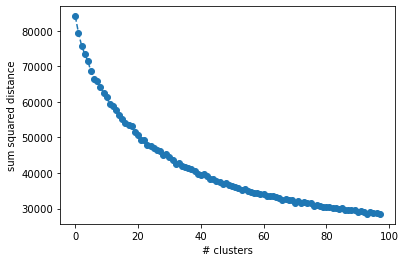

In [13]:
plt.plot(ssd,'o--')
plt.xlabel('# clusters')
plt.ylabel('sum squared distance')

In [14]:
diff = [ssd[i]-ssd[i-1] for i in range(1,len(ssd)-1)]
pd.Series(ssd).diff()

0             NaN
1    -4618.039032
2    -3630.586389
3    -2362.092496
4    -2013.802438
         ...     
93    -524.127686
94     541.749536
95    -372.280094
96     -41.694301
97    -148.377939
Length: 98, dtype: float64

<AxesSubplot:>

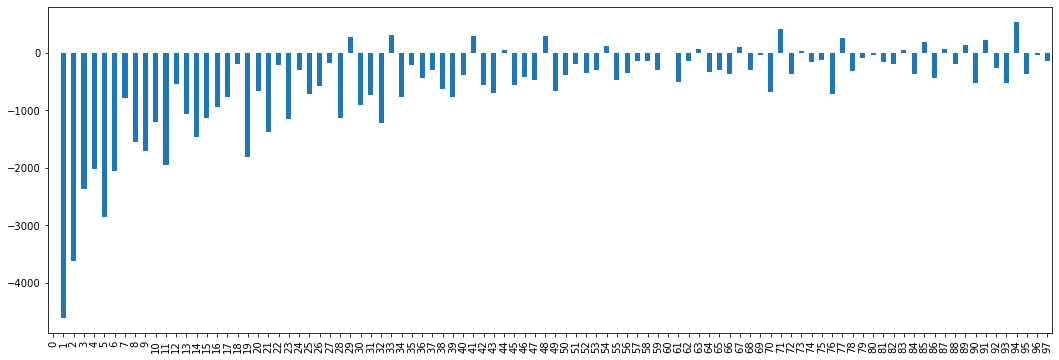

In [15]:
plt.figure(figsize=(18,6))
pd.Series(ssd).diff().plot(kind='bar')

SSD rate of change starts to decrease in the range of 10-15 clusters so we will set n_clusters=15 for our model

In [16]:
model = KMeans(n_clusters=15)
model.fit(X)

KMeans(n_clusters=15)

In [17]:
molecules['cluster_id'] = model.labels_

In [18]:
molecules['cluster_id'].value_counts()

13    259
1     179
2     157
9     151
4     138
8     110
7      78
5      75
11     73
3      70
14     61
6      41
0      35
10     34
12     24
Name: cluster_id, dtype: int64

In [19]:
molecules.groupby('cluster_id').mean().sort_values('pIC50',ascending=False)

pIC50         nbr
cluster_id                      
9           9.056231  288.152318
5           8.927658  295.120000
1           8.018662  205.122905
6           7.920100   60.878049
8           7.766114   87.663636
0           7.716033   19.400000
7           7.599795   69.923077
11          7.495559   68.465753
14          7.347454  113.245902
2           7.244238  161.885350
4           7.007851  195.688406
10          6.828223   52.029412
13          6.652759   27.706564
3           6.101083   36.942857
12          4.205792   25.041667

Cluster #2 possesses the highest average pIC50. If we use pIC50=6.3 as a separator between active and inactive, what percentage of molecules in cluster #2 are active? What about cluster #10 with the lowest average pIC50?

In [20]:
molecules['active'] = molecules['pIC50']>6.3

In [21]:
molecules

molecule_chembl_id                                             smiles  \
0           CHEMBL17157  CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...   
1           CHEMBL20345  O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCSc3ccc(...   
2           CHEMBL20818  COP(=O)(CCC1CCN(C[C@H]2CN([C@H](CC3CC3)C(=O)O)...   
3          CHEMBL280344  O=C(O)[C@@H](C1CCCCC1)N1C[C@H](CN2CCC(CCS(=O)(...   
4           CHEMBL21147  O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCCc3ccc(...   
...                 ...                                                ...   
1480      CHEMBL4517518        Nc1nc2[nH]c(C3CC3)c(Cc3cccc(Cl)c3)c(=O)n2n1   
1481      CHEMBL4519152  CC(=O)C1=C(O)C(=O)N(c2ccc(Cl)cc2F)[C@@H]1C1CCCCC1   
1482      CHEMBL4531005        CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1cccc(Cl)c1Cl   
1483      CHEMBL4544504      CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1ccc(Cl)c(Br)c1   
1484      CHEMBL4548396      CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1ccc(Cl)c(Cl)c1   

          pIC50  nbr                                                 fp  \
0      5.957424    2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1     10.000000  261  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
2      7.721246  254  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3      8.958607  307  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4      9.698970  292  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...         ...  ...                                                ...   
1480   3.243364    9  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1481   6.153045    1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1482   4.075721    9  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1483   3.939302    9  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1484   3.879426    9  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

      cluster_id  active  
0             13   False  
1              5    True  
2              5    True  
3              5    True  
4              5    True  
...          ...     ...  
1480          13   False  
1481          13   False  
1482          13   False  
1483          13   False  
1484          13   False  

[1485 rows x 7 columns]

In [22]:
molecules.groupby('cluster_id').mean().sort_values('pIC50',ascending=False)

pIC50         nbr    active
cluster_id                                
9           9.056231  288.152318  1.000000
5           8.927658  295.120000  0.986667
1           8.018662  205.122905  0.972067
6           7.920100   60.878049  0.975610
8           7.766114   87.663636  0.909091
0           7.716033   19.400000  0.828571
7           7.599795   69.923077  1.000000
11          7.495559   68.465753  0.849315
14          7.347454  113.245902  0.737705
2           7.244238  161.885350  0.853503
4           7.007851  195.688406  0.688406
10          6.828223   52.029412  0.794118
13          6.652759   27.706564  0.625483
3           6.101083   36.942857  0.357143
12          4.205792   25.041667  0.000000

All of the molecules in the most active cluster are classified as active while less than 50% of the least cluster is active.
Visualize some molecules from each cluster

In [23]:
ind_order = list(molecules.groupby('cluster_id').mean().sort_values('pIC50',ascending=False).index) #most active to least

In [24]:
PandasTools.AddMoleculeColumnToFrame(molecules,smilesCol='smiles')

In [25]:
cluster_best = molecules[molecules['cluster_id']==ind_order[0]]

In [26]:
mols2grid.display(cluster_best,smiles_col='smiles',mol_col='ROMol',subset=['img','molecule_chembl_id'],n_rows=3)

In [27]:
cluster_worst = molecules[molecules['cluster_id']==ind_order[-1]]
mols2grid.display(cluster_worst,smiles_col='smiles',mol_col='ROMol',subset=['img','molecule_chembl_id'],n_rows=3)

Upon visual inspection there are obvious structural differences between the most active and least active clusters.
What about between most active and the second most active?

In [28]:
cluster_2nd = molecules[molecules['cluster_id']==ind_order[1]]
mols2grid.display(cluster_2nd,smiles_col='smiles',mol_col='ROMol',subset=['img','molecule_chembl_id'],n_rows=3)

In [29]:
n_clusters = len(molecules['cluster_id'].unique())
cluster_list = [list(molecules[molecules['cluster_id']==i]['smiles']) for i in range(0,n_clusters)]
clusters=[]
for cluster in cluster_list:
    mols=[]
    for smiles in cluster:
        mols.append(Chem.MolFromSmiles(smiles))
    clusters.append(mols)
mcs_list = [rdFMCS.FindMCS(cluster) for cluster in clusters]

In [30]:
mcs_structs = [Chem.MolFromSmarts(mcs.smartsString) for mcs in mcs_list]

In [31]:
ind_order = list(molecules.groupby('cluster_id').mean().sort_values('pIC50',ascending=False).index)

In [38]:
sorted_mcs_structs = [mcs_structs[ind] for ind in ind_order]
mcs_df = pd.DataFrame(list(zip(ind_order,sorted_mcs_structs)),columns=['cluster_id','mcs_structure'])

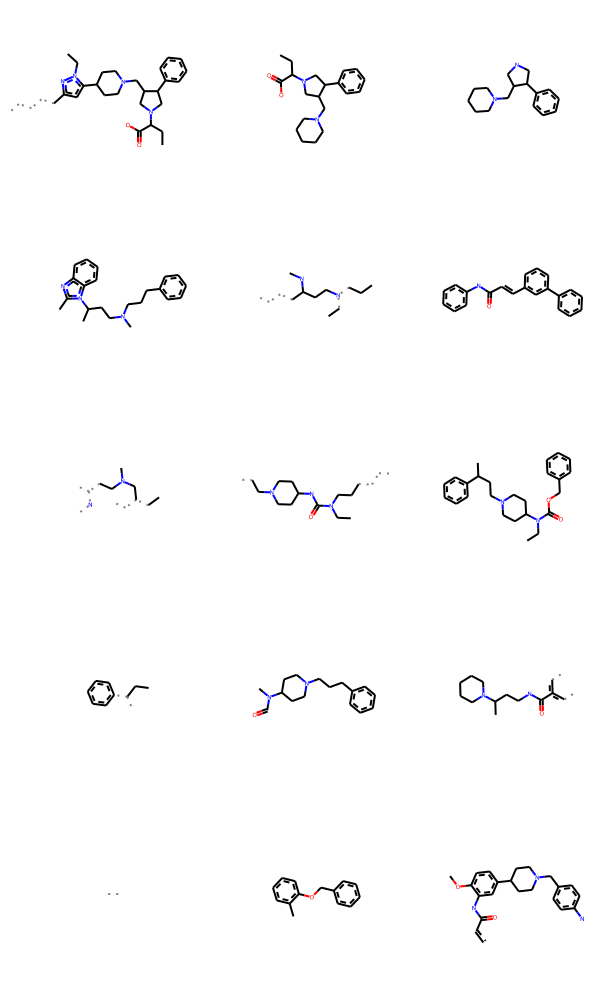

In [40]:
Draw.MolsToGridImage(mcs_df['mcs_structure'])

In [33]:
mols2grid.display(mcs_df,smiles_col=None,mol_col='mcs_structure',subset=['img','cluster_id'],size=(220,180),
                 n_rows=4,n_cols=4)

What happens if we lower the threshold when clustering?

In [34]:
n_clusters = len(molecules['cluster_id'].unique())
cluster_list = [list(molecules[molecules['cluster_id']==i]['smiles']) for i in range(0,n_clusters)]
clusters=[]
for cluster in cluster_list:
    mols=[]
    for smiles in cluster:
        mols.append(Chem.MolFromSmiles(smiles))
    clusters.append(mols)

In [35]:
mcs_best = rdFMCS.FindMCS(clusters[ind_order[0]],threshold=0.8)

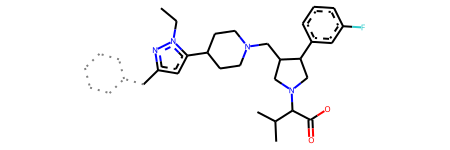

In [36]:
Chem.MolFromSmarts(mcs_best.smartsString)

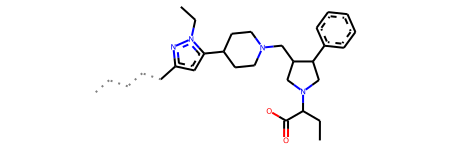

In [37]:
sorted_mcs_structs[0]

Found the same scaffold with a lower threshold but the 0.8 threshold adds a Fluorine to the aromatic ring.

Overall a scaffold that supports activity towards CCR5 was identified. Further evaluation will include a different number of clusters and different clustering algorithms to see if the same scaffold is found. Other clustering methods to look at are DBSCAN and Butina clustering.